# 怎么做

- 先撸一个baseline的model出来，再进行后续的分析步骤，一步步提高
- 经验
    - 1 对数据的认识太重要了
    - 2 数据中的特殊点/离群点的分析和处理太重要了
    - 3 特征工程(feature engineering)太重要了！甚至比model本身还要重要
    - 4 要做模型融合(model ensemble)

# 初探数据

In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame

data_train = pd.read_csv("input/train.csv")
data_train.iloc[0:3, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 列数据信息：

- PassengerId => 乘客ID
- Pclass => 乘客等级(1/2/3等舱位)
- Name => 乘客姓名
- Sex => 性别
- Age => 年龄
- SibSp => 堂兄弟/妹个数
- Parch => 父母与小孩个数
- Ticket => 船票信息
- Fare => 票价
- Cabin => 客舱
- Embarked => 登船港口

## 用DataFrame的info()方法获取信息

In [102]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### 缺失值

- Age 只有714名乘客有记录
- Cabin 只有204名乘客是已知的

## 用describe()方法获取信息

In [103]:
data_train.describe()

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 数据初步分析

## 乘客各属性分布

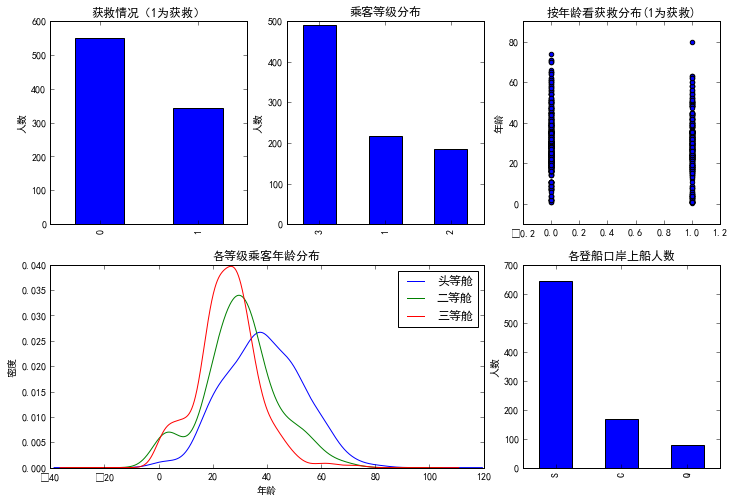

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
fig.set(alpha=0.1)

plt.subplot2grid((2, 3), (0, 0))
# 柱状图
data_train.Survived.value_counts().plot(kind="bar")
plt.title("获救情况（1为获救）")
plt.ylabel("人数")

plt.subplot2grid((2, 3), (0, 1))
data_train.Pclass.value_counts().plot(kind="bar")
plt.ylabel("人数")
plt.title("乘客等级分布")

plt.subplot2grid((2, 3), (0, 2))
plt.scatter(data_train.Survived, data_train.Age)
plt.ylabel("年龄")
plt.title("按年龄看获救分布(1为获救)")

plt.subplot2grid((2, 3), (1, 0), colspan=2)
data_train.Age[data_train.Pclass == 1].plot(kind="kde")
data_train.Age[data_train.Pclass == 2].plot(kind="kde")
data_train.Age[data_train.Pclass == 3].plot(kind="kde")
plt.title("各等级乘客年龄分布")
plt.xlabel("年龄")
plt.ylabel("密度")
plt.legend(("头等舱", "二等舱", "三等舱"), loc="best")

plt.subplot2grid((2, 3), (1, 2))
data_train.Embarked.value_counts().plot(kind="bar")
plt.title("各登船口岸上船人数")
plt.ylabel("人数")

plt.show()

## 属性与获救结果的关联统计

看看各乘客等级的获救情况

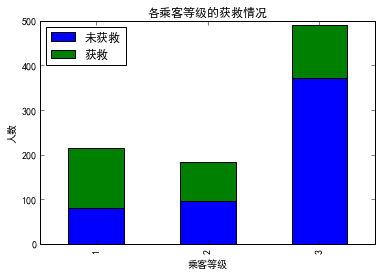

In [189]:
Survived_0 = data_train.Pclass[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Pclass[data_train.Survived == 1].value_counts()
df = pd.DataFrame({"获救": Survived_1, "未获救": Survived_0})
df.plot(kind="bar", stacked=True)
plt.title("各乘客等级的获救情况")
plt.xlabel("乘客等级")
plt.ylabel("人数")
plt.show()

看看性别的获救情况

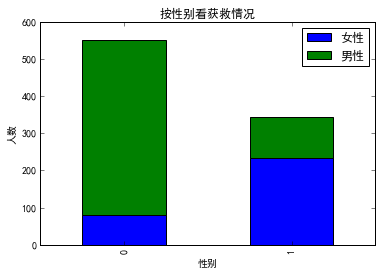

In [5]:
Survived_f = data_train.Survived[data_train.Sex == "female"].value_counts()
Survived_m = data_train.Survived[data_train.Sex == "male"].value_counts()
df = pd.DataFrame({"男性": Survived_m, "女性": Survived_f})
df.plot(kind="bar", stacked=True)
plt.title("按性别看获救情况")
plt.xlabel("性别")
plt.ylabel("人数")
plt.show()

详细版的性别和舱级别的获救情况

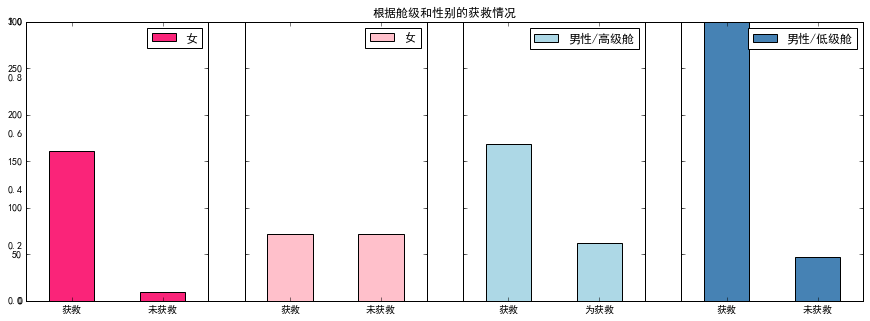

In [6]:
fig = plt.figure(figsize=(15, 5))
plt.title("根据舱级和性别的获救情况")
plt.xticks(())

ax1 = fig.add_subplot(141)
data_train.Survived[data_train.Sex == "female"][data_train.Pclass != 3] \
    .value_counts().plot(kind="bar", label="female higclass", color="#FA2479")
ax1.set_xticklabels(["获救", "未获救"], rotation=0)
ax1.legend(("女性/高级舱"), loc="best")

ax2 = fig.add_subplot(142, sharey=ax1)
data_train.Survived[data_train.Sex == "female"][data_train.Pclass == 3] \
    .value_counts().plot(kind="bar", label="female lowclass", color="pink")
ax2.set_xticklabels(["获救", "未获救"], rotation=0)
ax2.legend(("女性/低级舱"), loc="best")

ax3 = fig.add_subplot(143, sharey=ax1)
data_train.Survived[data_train.Sex == "male"][data_train.Pclass != 3] \
    .value_counts().plot(kind="bar", label="male higclass", color="lightblue")
ax3.set_xticklabels(["获救", "为获救"], rotation=0)
ax3.legend(["男性/高级舱"], loc="best")

ax4 = fig.add_subplot(144, sharey=ax1)
data_train.Survived[data_train.Sex == "male"][data_train.Pclass == 3] \
    .value_counts().plot(kind="bar", label="male lowclass", color="steelblue")
ax4.set_xticklabels(["获救", "未获救"], rotation=0)
ax4.legend(["男性/低级舱"], loc="best")

plt.show()

各登船港口的收获情况

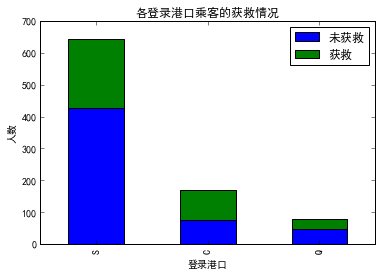

In [7]:
Survived_0 = data_train.Embarked[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Embarked[data_train.Survived == 1].value_counts()
df = pd.DataFrame({"获救": Survived_1, "未获救": Survived_0})
df.plot(kind="bar", stacked=True)
plt.title("各登录港口乘客的获救情况")
plt.xlabel("登录港口")
plt.ylabel("人数")
plt.show()

看看堂兄弟/妹，孩子/父母有几人，对是否获救的影响

In [104]:
g = data_train.groupby(["SibSp", "Survived"])
df = pd.DataFrame(g.count()["PassengerId"])
df

PassengerId
SibSp Survived             
0     0                 398
      1                 210
1     0                  97
      1                 112
2     0                  15
      1                  13
3     0                  12
      1                   4
4     0                  15
      1                   3
5     0                   5
8     0                   7

看看客舱的数据

In [105]:
data_train.Cabin.value_counts()

B96 B98            4
C23 C25 C27        4
G6                 4
D                  3
C22 C26            3
F33                3
F2                 3
E101               3
F G73              2
C93                2
D35                2
B49                2
C123               2
B5                 2
F4                 2
B35                2
C83                2
C126               2
B18                2
B58 B60            2
C124               2
D36                2
B51 B53 B55        2
B57 B59 B63 B66    2
E121               2
C78                2
E33                2
B77                2
B22                2
E25                2
                  ..
D28                1
A6                 1
E38                1
B82 B84            1
B3                 1
C32                1
C45                1
C70                1
E63                1
D15                1
D30                1
C54                1
A26                1
C30                1
E58                1
B102               1
D10 D12      

因为Cabin直接按类别分太散，估计每个因子化后的特征都拿不到什么权重，缺失值又多，暂且将缺失与否作为条件

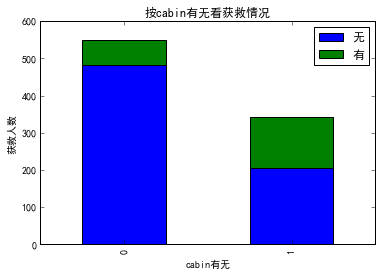

In [63]:
Survive_cabin = data_train.Survived[pd.notnull(data_train.Cabin)].value_counts()
Survive_nocabin = data_train.Survived[pd.isnull(data_train.Cabin)].value_counts()
df = pd.DataFrame({"有": Survive_cabin, "无": Survive_nocabin})
df.plot(kind="bar", stacked=True)

plt.title("按cabin有无看获救情况")
plt.xlabel("cabin有无")
plt.ylabel("获救人数")
plt.show()

# 简单数据预处理

## 缺失值的处理

- 如果缺值的样本占总数比例极高，我们可能就直接舍弃了
- 如果缺值的样本适中，而该属性非连续值特征属性，那就把NaN作为一个新类别
- 如果缺值的样本适中，而该属性为连续值特征属性，有时候我们会考虑给定一个step，然后把它离散化，之后把NaN作为一个type加到属性类目中
- 缺失的值个数并不是特别多，那我们也可以试着根据已有的值，拟合一下数据，补充上

使用RandomForest来拟合缺失的年龄数据

In [2]:
from sklearn.ensemble import RandomForestRegressor

# 使用RandomForestClassifier填补缺失的年龄属性
def set_missing_ages(df):
    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[["Age", "Fare", "Parch", "SibSp", "Pclass"]]
    
    # 乘客分为已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()
    
    # y即目标年龄
    y = known_age[:, 0]
    # X即特征属性值
    X = known_age[:, 1:]
    
    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)
    
    # 用得到的模型进行未知年龄预测
    predictedAges = rfr.predict(unknown_age[:, 1::])

    # 用得到的预测结果填补原缺失数据
    df.loc[(df.Age.isnull()), "Age"] = predictedAges
    
    return df, rfr

def  set_Cabin_type(df):
    df.loc[(df.Cabin.notnull()), "Cabin"] = "Yes"
    df.loc[(df.Cabin.isnull()), "Cabin"] = "No"
    return df

data_train, rfr = set_missing_ages(data_train)
data_train = set_Cabin_type(data_train)
data_train[["Age", "Cabin"]].iloc[:10]

,Age,Cabin
0,22.000000,No
1,38.000000,Yes
2,26.000000,No
3,35.000000,Yes
4,35.000000,No
5,23.838953,No
6,54.000000,Yes
7,2.000000,No
8,27.000000,No
9,14.000000,No


## 对类目型的特征因子化

In [3]:
dummies_Cabin = pd.get_dummies(data_train["Cabin"], prefix="Cabin")
dummies_Embarked = pd.get_dummies(data_train["Embarked"], prefix="Embarked")
dummies_Sex = pd.get_dummies(data_train["Sex"], prefix="Sex")
dummies_Pclass = pd.get_dummies(data_train["Pclass"], prefix="Pclass")

df = pd.concat([data_train, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)

df.drop(["Pclass", "Cabin", "Embarked", "Sex", "Name", "Ticket"], axis=1, inplace=True)
df.iloc[:3]

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,1,0,22.0,1,0,7.2500,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,2,1,38.0,1,0,71.2833,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3,1,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


## 将属性值做scaling

各属性值之间的scale差距过大，将影响收敛速度，甚至不收敛

In [4]:
import sklearn.preprocessing as preprocessing

scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(df["Age"].reshape(-1, 1))
df["Age_scaled"] = scaler.fit_transform(df["Age"].reshape(-1, 1), age_scale_param)

fare_scale_param = scaler.fit(df["Fare"].reshape(-1, 1))
df["Fare_scaled"] = scaler.fit_transform(df["Fare"].reshape(-1, 1), fare_scale_param)

df[0:10]

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Age_scaled,Fare_scaled
0,1,0,22.000000,1,0,7.2500,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,-0.561380,-0.502445
1,2,1,38.000000,1,0,71.2833,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.613171,0.786845
2,3,1,26.000000,0,0,7.9250,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,-0.267742,-0.488854
3,4,1,35.000000,1,0,53.1000,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.392942,0.420730
4,5,0,35.000000,0,0,8.0500,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.392942,-0.486337
5,6,0,23.838953,0,0,8.4583,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.426384,-0.478116
6,7,0,54.000000,0,0,51.8625,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.787722,0.395814
7,8,0,2.000000,3,1,21.0750,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,-2.029569,-0.224083
8,9,1,27.000000,0,2,11.1333,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,-0.194333,-0.424256
9,10,1,14.000000,1,0,30.0708,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.148655,-0.042956


# 逻辑回归建模

把feature字段取出来，转成numpy格式， 使用scikit-learn中的LogisticRegression建模

In [5]:
from sklearn import linear_model

# 用正则取出我们要的属性值
train_df = df.filter(regex="Survived|SibSp|Parch|Cabin_*|Embarked_*|Sex_*|Pclass_*|Age_.*|Fare_.*")
train_np = train_df.as_matrix()

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

clf = linear_model.LogisticRegression()
clf.fit(X, y)

clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## 测试数据预处理

In [6]:
data_test = pd.read_csv("input/test.csv")
# data_test.info()
data_test.loc[(data_test.Fare.isnull()), "Fare"] = 0

# 用同样的RandomForestRegression模型填上丢失的年龄
tmp_df = data_test[["Age", "Fare", "Parch", "SibSp", "Pclass"]]
null_age = tmp_df[data_test.Age.isnull()].as_matrix()

# 根据特征属性X预测年龄并补上
X = null_age[:, 1:]

predictedAges = rfr.predict(X)
data_test.loc[(data_test.Age.isnull()), "Age"] = predictedAges

data_test = set_Cabin_type(data_test)

dummies_Cabin = pd.get_dummies(data_test["Cabin"], prefix="Cabin")
dummies_Embarked = pd.get_dummies(data_test["Embarked"], prefix="Embarked")
dummies_Sex = pd.get_dummies(data_test["Sex"], prefix="Sex")
dummies_Pclass = pd.get_dummies(data_test["Pclass"], prefix="Pclass")

df_test = pd.concat([data_test, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df_test.drop(["Pclass", "Name", "Sex", "Ticket", "Cabin", "Embarked"], axis=1, inplace=True)

df_test["Age_scaled"] = scaler.fit_transform(df_test["Age"].reshape(-1, 1), age_scale_param)
df_test["Fare_scaled"] = scaler.fit_transform(df_test["Fare"].reshape(-1, 1), fare_scale_param)

df_test[:10]

,PassengerId,Age,SibSp,Parch,Fare,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Age_scaled,Fare_scaled
0,892,34.5,0,0,7.8292,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.307521,-0.496637
1,893,47.0,1,0,7.0000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.256241,-0.511497
2,894,62.0,0,0,9.6875,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.394706,-0.463335
3,895,27.0,0,0,8.6625,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,-0.261711,-0.481704
4,896,22.0,1,1,12.2875,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,-0.641199,-0.416740
5,897,14.0,0,0,9.2250,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,-1.248380,-0.471623
6,898,30.0,0,0,7.6292,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.034018,-0.500221
7,899,26.0,1,1,29.0000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.337609,-0.117238
8,900,18.0,0,0,7.2292,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.944790,-0.507390
9,901,21.0,2,0,24.1500,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,-0.717097,-0.204154


## 测试预测

In [7]:
test = df_test.filter(regex="Survived|SibSp|Parch|Cabin_*|Embarked_*|Sex_*|Pclass_*|Age_.*|Fare_.*")
predictions = clf.predict(test)
result = pd.DataFrame({"PassengerId": data_test["PassengerId"].as_matrix(), "Survived": predictions.astype(np.int32)})
result[:10]

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


# 逻辑回归系统优化

## 模型系数关联分析

In [8]:
pd.DataFrame({"columns": list(train_df.columns)[1:], "coef": list(clf.coef_.T)})

,coef,columns
0,[-0.348732570366],SibSp
1,[-0.114805876261],Parch
2,[-0.324126047969],Cabin_No
3,[0.603344690926],Cabin_Yes
4,[0.179653939384],Embarked_C
5,[0.168432936995],Embarked_Q
6,[-0.258545490503],Embarked_S
7,[1.45462032859],Sex_female
8,[-1.17540168564],Sex_male
9,[0.71269556996],Pclass_1


## 交叉验证

In [9]:
from sklearn import  cross_validation

clf = linear_model.LogisticRegression()
all_data = df.filter(regex="Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*")
X = all_data.as_matrix()[:, 1:]
y = all_data.as_matrix()[:, 0]
print(cross_validation.cross_val_score(clf, X, y, cv=5).mean())

0.80358186629


C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


分割数据，按照cv 7;3的比例看看bad case

In [10]:
split_train, split_cv = cross_validation.train_test_split(df, test_size=0.3, random_state=0)
train_df = split_train.filter(regex="Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*")

clf = linear_model.LogisticRegression()
clf.fit(train_df.as_matrix()[:, 1:], train_df.as_matrix()[:, 0])

cv_df = split_cv.filter(regex="Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*")
predictions = clf.predict(cv_df.as_matrix()[:, 1:])

origin_data_train = pd.read_csv("input/train.csv")
bad_cases = origin_data_train.loc[origin_data_train["PassengerId"].isin(split_cv[predictions != cv_df.as_matrix()[:, 0]]["PassengerId"].values)]

bad_cases

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.00,0,0,350406,7.8542,NaN,S
49,50,0,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18.00,1,0,349237,17.8000,NaN,S
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S
65,66,1,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.00,4,2,3101281,7.9250,NaN,S
85,86,1,3,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",female,33.00,3,0,3101278,15.8500,NaN,S
113,114,0,3,"Jussila, Miss. Katriina",female,20.00,1,0,4136,9.8250,NaN,S
140,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,NaN,C
204,205,1,3,"Cohen, Mr. Gurshon ""Gus""",male,18.00,0,0,A/5 3540,8.0500,NaN,S
240,241,0,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C


## learning curves

特征越来越多，用这些特征去训练模型，可能会发生过拟合问题

### 过拟合的优化

- 做一下feature selection，挑选出较好的feature的subset来做training
- 提供更多的数据，从而弥补原始数据的bias问题，学习到的model也会更准确

(0.80670719367698362, 0.016295004129607826)

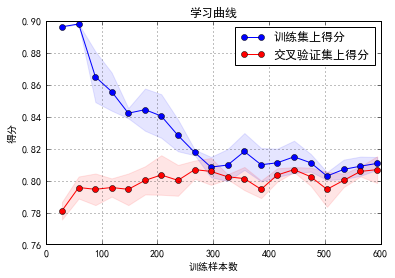

In [32]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,
                       train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    参数解释
    ---------
    estimator ： 分类器
    title : 表格标题
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax)
    cv : cv分成的份数
    n_jobs : 并行的任务数
    """
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes, verbose=verbose)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel("训练样本数")
        plt.ylabel("得分")
        plt.gca().invert_yaxis()
        plt.grid()
        
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                         train_scores_mean + train_scores_std, alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="r")
        
        plt.plot(train_sizes, train_scores_mean, "o-", color="b", label="训练集上得分")
        plt.plot(train_sizes, test_scores_mean, "o-", color="r", label="交叉验证集上得分")
        
        plt.legend(loc="best")
        
        plt.gca().invert_yaxis()
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff
        
plot_learning_curve(clf, "学习曲线", X, y)

# 模型融合（model ensemble）

用scikit-learn里面的Bagging来完成模型融合

In [33]:
from sklearn.ensemble import BaggingRegressor

train_df = df.filter(regex="Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*|Mother|Child|Family|Title")
train_np = train_df.as_matrix()

X = train_np[:, 1:]
y = train_np[:, 0]

clf = linear_model.LogisticRegression(penalty="l1")
bagging_clf = BaggingRegressor(clf, n_estimators=20, max_samples=0.8, max_features=1.0,
                              bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(X, y)

test = df_test.filter(regex="Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*|Mother|Child|Family|Title")
predictions = bagging_clf.predict(test)
result = pd.DataFrame({"passengerId": data_test["PassengerId"].as_matrix(), "Survived": predictions.astype(np.int32)})

result


,Survived,passengerId
0,0,892
1,0,893
2,0,894
3,0,895
4,0,896
5,0,897
6,1,898
7,0,899
8,1,900
9,0,901


# 总结

机器学习解决问题的过程大致如下图所示

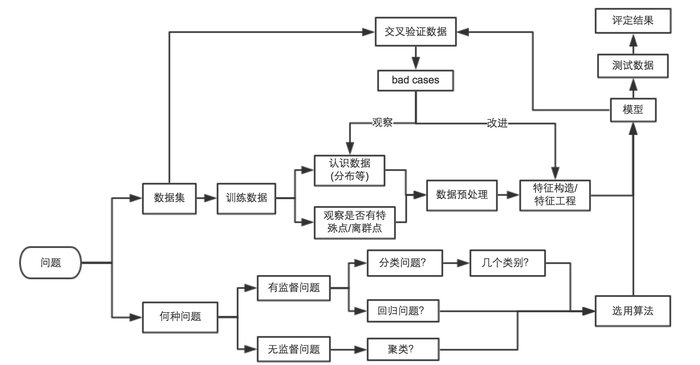

In [35]:
from IPython.display import Image

Image(filename="static/process.jpg")